For this project we are going to evaluate the quality of generative models for data augmentation in medical domain.

You will augment data using both a Variational Auto-Encoder, an Auto-Encoder (a regular Auto-Encoder, or any kind of Auto-Encoder you will decide to use, like for example a Denoising Auto-Encoder), and a Generative Adversarial Network (here again, you will choose the GAN model: GAN, DCGAN, Wasserstein GAN, etc.).



You will use these 3 kind of models to generate new data and evaluate the (possible) improvement of the final classification score compared with augmenting the training set and without. 



In order to confirm the impact of your data augmentation strategies, you will apply them on 8 of the datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/). You will use:

- PathMNIST	Pathology	Multi-Class (9)	89,996	10,004	7,180

- DermaMNIST	Dermatoscope	Multi-Class (7)	7,007	1,003	2,005

- OCTMNIST	OCT	Multi-Class (4)	97,477	10,832	1,000

- PneumoniaMNIST	Chest X-ray	Binary-Class (2)	4,708	524	624

- BreastMNIST	Breast Ultrasound	Binary-Class (2)	546	78	156

- OrganMNIST_Axial	Abdominal CT	Multi-Class (11)	34,581	6,491	17,778

- OragnMNIST_Coronal	Abdominal CT	Multi-Class (11)	13,000	2,392	8,268

- OrganMNIST_Sagittal	Abdominal CT	Multi-Class (11)



You will not use: RetinaMNIST which is a regression oriented dataset and ChestMNIST which is a multi-label dataset

- RetinaMNIST	Fundus Camera	Ordinal Regression (5)	1,080	120	400

- ChestMNIST	Chest X-ray	Multi-Label (14) Binary-Class (2)	78,468	11,219	22,433



To load these datasets in Google Colab, you can mount the official drive containing these datasets (from https://medmnist.github.io/): https://drive.google.com/drive/folders/1Tl_SP-ffDQg-jDG_EWPlWKgZTmGbvFXU



You can directly load these datasets inside your Google Colab without impacting the space in your Google Drive by using the commands you can find on the following page: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/numpy.ipynb



You will provide us with one Google Colab link (all the architectures have to be evaluated on the same notebook) and a short report of few pages (typically 4 or 5) explaining your choices of VAE, AE, and GAN models (among all variants), if you notice differences between datasets' results you will try to interprete and justify these differences w.r.t. models, data specifications, visual features, and the bibliography references you will have found to support all your choices. The goal is not to get better results for all data sets, but rather to explore whether or not data augmentation using generative models can be useful. Therefore, presenting negative results can be interesting as well.





 



In [1]:
import numpy as np
import tensorflow as tf
from google.colab import drive
from google.colab import files

In [2]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras import backend as K
from keras.losses import binary_crossentropy
from numpy import reshape
import matplotlib.pyplot as plt

## Load the data and reshape them. 

We'll start loading the dataset and check the dimensions.

In [3]:
uploaded=files.upload()

Saving pneumoniamnist.npz to pneumoniamnist.npz


In [4]:
#test to see the data

#breastmnist= np.load('breastmnist.npz')
#dermamnist= np.load('dermamnist (2).npz') #shape 3 to see at the end
#octmnist= np.load('octmnist.npz')
#organmnist_axial= np.load('organmnist_axial.npz')
#organmnist_coronal= np.load('organmnist_coronal.npz')
#organmnist_sagittal= np.load('organmnist_sagittal.npz')
#pathmnist= np.load('pathmnist.npz') #shape 3 to see at the end
pneumoniamnist= np.load('pneumoniamnist.npz')

In [5]:
data=pneumoniamnist

In [6]:
x_train = data['train_images']
y_train = data['train_labels'] 
x_test = data['test_images']
y_test = data['test_labels']

When we look at the shape of the data we notice that for dermamnist and pathmnist the shape is (nbr_images, size_img, size_img, 3). For these specials cases seen at the end we will need to transform the data from color (RGB) to black and white. 

In [7]:
print(x_train.shape, x_test.shape)

(4708, 28, 28) (624, 28, 28)


In [8]:
print(y_train.shape, y_test.shape)

(4708, 1) (624, 1)


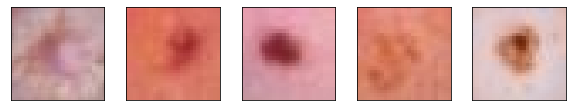

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i,:], cmap=plt.cm.binary)

plt.show()

The first element is sample numbers, the second and third elements are the dimension (width and height) of the image. We'll reshape the array.

In [ ]:
from skimage.color import rgb2gray
x_train = rgb2gray(x_train)
x_test = rgb2gray(x_test)

In [ ]:
x_train.shape

(7007, 28, 28)

In [9]:
image_size = x_train.shape[1]
x_train = reshape(x_train, [-1, image_size, image_size, 1])
x_test = reshape(x_test, [-1, image_size, image_size, 1])

print(x_train.shape, x_test.shape)

(4708, 28, 28, 1) (624, 28, 28, 1)


Next, we'll scale the array data.

In [10]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255 

In [ ]:
x_train.shape

(89996, 28, 28, 1)

## Classification on the dataset without data augmentation. 

We use a basic neural network classifier from tf.keras working for multi-class so we won't have to change the classification model. We will evaluate the model with the loss and the accuracy. 

In [11]:
x_train_reshape= x_train.reshape(x_train.shape[0], 28, 28)

In [12]:
model_class = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])
model_class.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We feed the model.

In [13]:
y_train.shape

(4708, 1)

In [14]:
model_class.fit(x_train, y_train, epochs=20)

Epoch 1/20
148/148 [==============================] - 1s 2ms/step - loss: 0.5604 - accuracy: 0.7413
Epoch 2/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2300 - accuracy: 0.9025
Epoch 3/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9233
Epoch 4/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9363
Epoch 5/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1429 - accuracy: 0.9447
Epoch 6/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.9496
Epoch 7/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9430
Epoch 8/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.9416
Epoch 9/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1483 - accuracy: 0.9410
Epoch 10/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9597

Next, compare how the model performs on the test dataset:

In [15]:
test_loss, test_acc = model_class.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 0s - loss: 1.3479 - accuracy: 0.7019

Test accuracy: 0.7019230723381042


### Results without data augmentation. 
For the breastminst we obtain with 20 epochs: loss: 0.4672 - accuracy: 0.7949. 

For the octomninst after training: loss: 1.0746 - accuracy: 0.5790

For the dermamnist after training: loss: 1.0543 - accuracy: 0.6688 and before 1.0499 - accuracy: 0.6744. 


## Augmentation of the data

### Model 1: Variational Auto-Encoder

The variational autoencoders apply some statistical findings by using learned mean and standard deviations to learn the distribution. The latent space mean and variance are kept to update in each layer and this helps to improve the generator model. We will create our model with keras. 

First step is to create the encoder. Encoder is convolutional network model to receive input data and transform it into the latent space array. Here, we need to define sampling function to use in encoding layer. The latent space sampling function helps to sample the distribution by using mean and variance and returns sampled latent vector.

In [16]:
latent_dim = 8 

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

After the first layers, we'll extract the mean and log variance of this layer. We can create a z layer based on those two parameters to generate an input image.

In [17]:
input_img = Input(shape=(image_size, image_size, 1),)

h=Conv2D(16,kernel_size=3,activation='relu',padding='same',strides=2)(input_img)
enc_ouput=Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=2)(h) #parameters? 

shape = K.int_shape(enc_ouput)
x = Flatten()(enc_ouput)
x = Dense(16, activation='relu')(x) #different activation fct
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 32)     4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1568)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

Now, we create the decoder, the decoder model generates the image from the latent input layer. 

In [18]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x=Conv2DTranspose(32, kernel_size=3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(16, kernel_size=3,activation='relu',strides=2,padding='same')(x)
dec_output=Conv2DTranspose(1, kernel_size=3, activation='relu',padding='same')(x)

decoder = Model(latent_inputs, dec_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              14112     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 28,129
Trainable params: 28,129
Non-trainable params: 0
_______________________________________________________

Finally, we'll define the VAE model. The VAE model combines both encoder and decoder layers. We need to define the loss function and it into the model.

In [19]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

reconst_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconst_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconst_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 8), (None, 8 30176       input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    28129       encoder[0][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 16)   160         input_1[0][0]                    
________________________________________________________________________________________________

We fit the model on training data.

In [20]:
vae.fit(x_train,epochs=20,batch_size=128,shuffle=True,validation_data=(x_test,None))

Epoch 1/20
37/37 [==============================] - 6s 125ms/step - loss: 1103.0834 - val_loss: 556.6215
Epoch 2/20
37/37 [==============================] - 4s 112ms/step - loss: 553.8213 - val_loss: 647.8173
Epoch 3/20
37/37 [==============================] - 4s 110ms/step - loss: 553.9731 - val_loss: 533.3665
Epoch 4/20
37/37 [==============================] - 4s 112ms/step - loss: 536.2012 - val_loss: 540.2882
Epoch 5/20
37/37 [==============================] - 4s 111ms/step - loss: 530.5860 - val_loss: 529.3864
Epoch 6/20
37/37 [==============================] - 4s 111ms/step - loss: 528.8245 - val_loss: 521.4324
Epoch 7/20
37/37 [==============================] - 4s 112ms/step - loss: 525.5297 - val_loss: 520.6648
Epoch 8/20
37/37 [==============================] - 4s 112ms/step - loss: 523.1448 - val_loss: 519.4426
Epoch 9/20
37/37 [==============================] - 4s 113ms/step - loss: 519.8849 - val_loss: 527.4713
Epoch 10/20
37/37 [==============================] - 4s 111ms/s

### Model 2: Auto-Encoder 

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [22]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [23]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [24]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
148/148 [==============================] - 1s 4ms/step - loss: 0.0211 - val_loss: 0.0123
Epoch 2/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 3/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 4/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 7/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 8/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 9/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 10/20
148/148 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0052

In [25]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

### Model 3: Generative Adversarial Network (DCGAN)

##### Normalization of the data. 

In [28]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [29]:
x_train.shape

(4708, 28, 28, 1)

In [30]:
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [31]:
train_images.shape

(4708, 28, 28, 1)

In [32]:
BUFFER_SIZE =train_images.shape[0]
BATCH_SIZE = 256

In [33]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

##### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [35]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

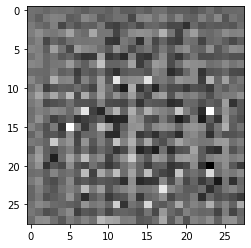

In [36]:
#untrained
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##### The discriminator 
It is a CNN-based image classifier.

In [37]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [38]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0007846]], shape=(1, 1), dtype=float32)


##### Define the loss and optimizers

In [39]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [40]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [41]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

##### Training of the model

In [44]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = BUFFER_SIZE

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [46]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    predictions=generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return predictions

In [47]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  return predictions

In [48]:
predictions=train(train_dataset, EPOCHS)

Time for epoch 20 is 109.97557282447815 sec


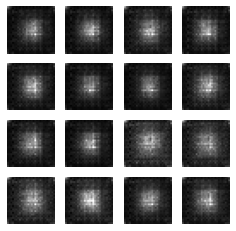

In [49]:
#the 16th first generated images in a plot
fig = plt.figure(figsize=(4,4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('image_at_epoch_{:04d}.png'.format(50))
plt.show()

In [50]:
predictions.shape

TensorShape([4708, 28, 28, 1])

In [51]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [52]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

## Generation of new data

### From the model 1: The variational-autoencoder

To generate images, first we'll encode test data with encoder and extract z_mean value. Then we'll predict it with decoder.

In [ ]:
z_mean, _, _ = encoder.predict(x_test)
decoded_imgs = decoder.predict(z_mean)

We visualize the first five images of both original and predicted data before to evaluate the quality of the model.

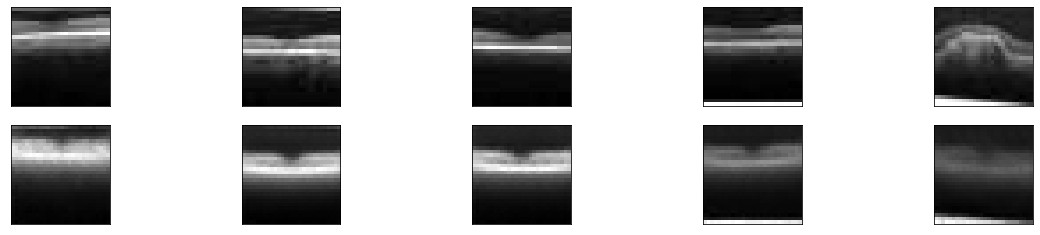

In [ ]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
	plt.gray()
	ax = plt.subplot(2, n, i+1)
	plt.imshow(x_test[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
	
	ax = plt.subplot(2, n, i +1+n)
	plt.imshow(decoded_imgs[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
plt.show()

The quality seems really poor. 

### From the model 2: Auto-Encoder 

In [ ]:
x_test.shape

(1000, 28, 28, 1)

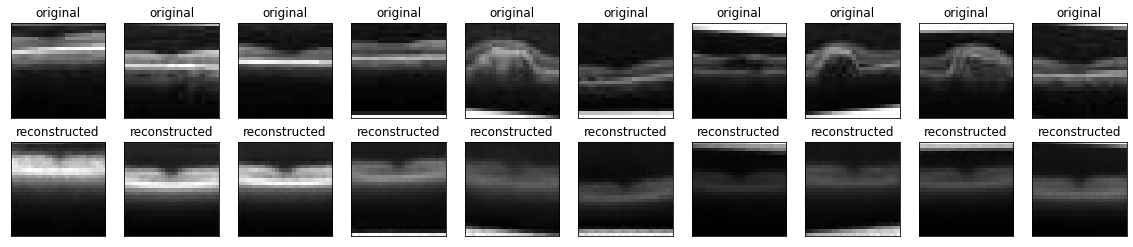

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28) )
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### From the model 3: Generative Adversarial Network

In [ ]:
display_image(EPOCHS)

NameError: ignored

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=True)

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Evaluation of the quality of generative models for data augmentation 

We will now evaluate the quality of our models. For the sake of legibility you will find the results commented for all the dataset in the written report. We evaluate how well the loss and accuracy of the model for a given dataset.

In [26]:
#for the model 1: VAE
z_mean_train, _, _ = encoder.predict(x_train)
decoded_imgs_train = decoder.predict(z_mean_train)
model_class.fit(decoded_imgs_train, y_train, epochs=20)
test_loss, test_acc = model_class.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/20
148/148 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8728
Epoch 2/20
148/148 [==============================] - 0s 2ms/step - loss: 0.3090 - accuracy: 0.8721
Epoch 3/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2943 - accuracy: 0.8781
Epoch 4/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.8849
Epoch 5/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.8800
Epoch 6/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2820 - accuracy: 0.8821
Epoch 7/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2803 - accuracy: 0.8851
Epoch 8/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.8821
Epoch 9/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2756 - accuracy: 0.8866
Epoch 10/20
148/148 [==============================] - 0s 2ms/step - loss: 0.2697 - accuracy: 0.8864

In [27]:
#for the model 2: Basic Autoencoder
encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs_ae = autoencoder.decoder(encoded_imgs).numpy()
model_class.fit(decoded_imgs_ae, y_train, epochs=20)
test_loss, test_acc = model_class.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Epoch 1/20
148/148 [==============================] - 1s 2ms/step - loss: 0.1877 - accuracy: 0.9227
Epoch 2/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9295
Epoch 3/20
148/148 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9316
Epoch 4/20
148/148 [==============================] - 0s 3ms/step - loss: 0.1680 - accuracy: 0.9344
Epoch 5/20
148/148 [==============================] - 0s 3ms/step - loss: 0.1625 - accuracy: 0.9308
Epoch 6/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9371
Epoch 7/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9390
Epoch 8/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1588 - accuracy: 0.9361
Epoch 9/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9407
Epoch 10/20
148/148 [==============================] - 0s 2ms/step - loss: 0.1650 - accuracy: 0.9344

In [ ]:
predictions.shape

NameError: ignored

In [54]:
#for the model 3: GAN
model_class.fit(predictions, y_train, epochs=20)
test_loss, test_acc = model_class.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Epoch 1/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.7421
Epoch 2/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7421
Epoch 3/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.7421
Epoch 4/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7421
Epoch 5/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5749 - accuracy: 0.7421
Epoch 6/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7421
Epoch 7/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7421
Epoch 8/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5738 - accuracy: 0.7421
Epoch 9/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5748 - accuracy: 0.7421
Epoch 10/20
148/148 [==============================] - 0s 2ms/step - loss: 0.5741 - accuracy: 0.7421

### Results after data augmentation:



For the **brestminst dataset** with 20 epochs we obtain: 
- **for the vae:**[train set] loss: 0.4949 - accuracy: 0.7747 [test set]loss: 0.5063 - accuracy: 0.7692
-**for the autoencoder:**[train set] loss: 0.4949 - accuracy: 0.7747 [test set]loss: 0.4656 - accuracy: 0.8077
-**for DCGAN:** [train set] loss: 0.5648 - accuracy: 0.7326[test set] loss: 0.4595 - accuracy: 0.8077

For the **dermamnist dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]


For the **octmnist dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]

For the **organmnist_axial dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]

For the **organmnist_coronal dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]

For the **organmnist_sagittal dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]

For the **pathmnist dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]

For the **pneumoniamnist dataset** with 20 epochs we obtain:

- **for the vae**:[train set] [test set]
- **for the autoencoder**:[train set] [test set]
- **for DCGAN**: [train set] [test set]